# Demo of usage of the MultiGeometryFiber class of pyFAI

For this tutorial, we will use the *Jupyter* notebook, formerly known as ipython, an take advantage of the integration of matplotlib.

In [1]:
%matplotlib inline
# use `widget` for better user experience; `inline` is for documentation generation

import time
start_time = time.perf_counter()

import numpy
from matplotlib.pyplot import subplots

import pyFAI
from pyFAI.method_registry import IntegrationMethod
from pyFAI.gui import jupyter
print("Using pyFAI version: ", pyFAI.version)

Using pyFAI version:  2025.3.0


- The multi_geometry module of pyFAI allows you to integrate multiple images taken at various image position, all together.
- MultiGeometryFiber is essentially a copy of MultiGeometry but with access to the integratexd_fiber (grazing-incidence) methods
- This tutorial will explain you how to perform fiber integration in three use-case: translation of the detector, rotation of the detector around the sample and finally how to fill gaps of a pixel detector. But before, we need to know how to generate fake diffraction image.

## Generation of diffraction images
PyFAI knows about 20 different reference sample called calibrants. We will use them to generate fake diffraction images knowing the detector and its position in space

In [2]:
import pyFAI.calibrant
print("Number of known calibrants: %s"%len(pyFAI.calibrant.ALL_CALIBRANTS))
print(", ".join(pyFAI.calibrant.ALL_CALIBRANTS.keys()))

Number of known calibrants: 32
hydrocerussite, ZnO, C14H30O, CeO2, CuO, vanadinite, Si, Si_SRM640e, Si_SRM640, LaB6_SRM660b, quartz, Si_SRM640a, LaB6, CrOx, Au, alpha_Al2O3, lysozyme, NaCl, LaB6_SRM660a, Si_SRM640d, Pt, mock, TiO2, Cr2O3, AgBh, Al, LaB6_SRM660c, Si_SRM640b, PBBA, cristobaltite, Si_SRM640c, Ni


In [3]:
wavelength = 1e-10
LaB6 = pyFAI.calibrant.get_calibrant("LaB6")
LaB6.set_wavelength(wavelength)
print(LaB6)
print("Number of reflections for calibrant at given wavelength: %i"%len(LaB6.get_dSpacing()))

LaB6 Calibrant with 59 reflections at wavelength 1e-10
Number of reflections for calibrant at given wavelength: 59


We will start with a "simple" detector called *Titan* (build by *Oxford Diffraction* but now sold by *Agilent*). It is a CCD detector with scintilator and magnifying optics fibers. The pixel size is constant: 60µm 

In [4]:
import pyFAI.detectors
det = pyFAI.detectors.Titan()
print(det)
p1, p2, p3 = det.calc_cartesian_positions()
print("Detector is flat, P3= %s"%p3)
poni1 = p1.mean()
poni2 = p2.mean()
print("Center of the detector: poni1=%s poni2=%s"%(poni1, poni2))

Detector Titan 2k x 2k%s	 PixelSize= 60µm, 60µm
Detector is flat, P3= None
Center of the detector: poni1=0.06144 poni2=0.06143988


The detector is placed orthogonal to the beam at 10cm. This geometry is saved into an *FiberIntegrator* instance:

In [5]:
from pyFAI.integrator.fiber import FiberIntegrator
fi = FiberIntegrator(dist=0.1, poni1=poni1, poni2=poni2, detector=det, wavelength=wavelength)
print(fi)

#Selection of the methods for integrating
method = IntegrationMethod.parse("full", dim=1)
method2d = IntegrationMethod.select_one_available(("pseudo","histogram","cython"), dim=2)

print(f"Integration method in 1d: {method}\nIntegration method in 2d: {method2d}")

Detector Titan 2k x 2k%s	 PixelSize= 60µm, 60µm
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 6.144000e-02, 6.143988e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=1023.998, y=1024.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å
Incident angle: 0.00° Tilt angle 0.00° Sample orientation 1
Integration method in 1d: IntegrationMethod(1d int, full split, histogram, cython)
Integration method in 2d: IntegrationMethod(2d int, pseudo split, histogram, cython)


Knowing the calibrant, the wavelength, the detector and the geometry, one can simulate the 2D diffraction pattern:

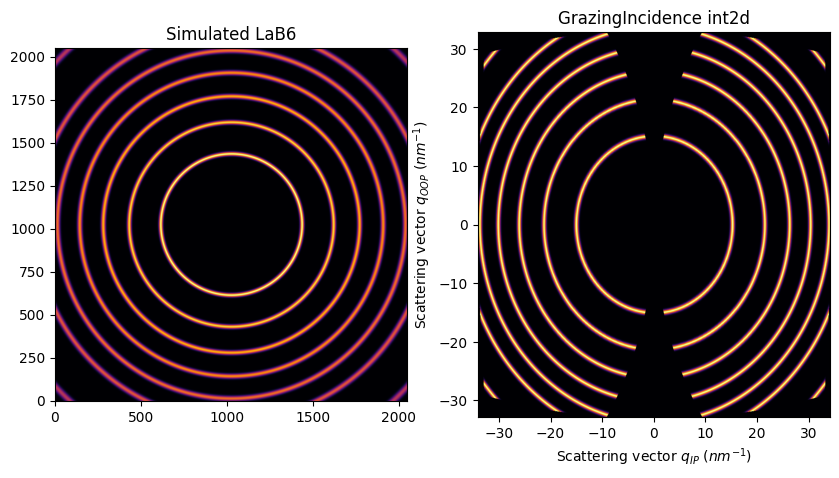

In [6]:
fig, axes = jupyter.subplots(ncols=2, figsize=(10,5))
img = LaB6.fake_calibration_image(fi)
res2d_gi = fi.integrate2d_grazing_incidence(data=img)
jupyter.display(img, label="Simulated LaB6", ax=axes[0])
jupyter.plot2d(res2d_gi, label="GrazingIncidence int2d", ax=axes[1])
pass

This image can be integrated in q-space and plotted:

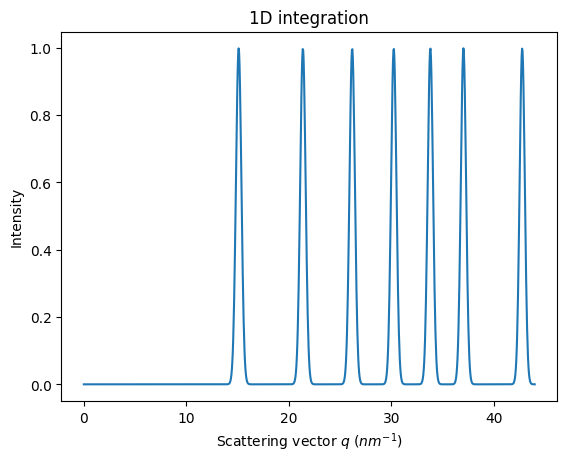

In [7]:
fig, ax = jupyter.subplots()
jupyter.plot1d(fi.integrate1d(img, 1000, method=method), ax=ax)
pass

Note pyFAI does now about the ring position but nothing about relative intensities of rings.

## Translation of the detector along the vertical axis

The vertical axis is defined along the *poni1*. If one moves the detector higher, the poni will appear at lower coordinates.
So lets define 5 upwards verical translations of half the detector size. 

For this we will duplicate 5x the AzimuthalIntegrator object, but instances of *AzimuthalIntegrator* are mutable, so it is important to create an actual *copy* and not an *view* on them. In Python, one can use the *copy* function of the *copy* module:

In [8]:
import copy

We will now offset the *poni1* value of each FiberIntegrator which correspond to a vertical translation. Each subsequent image is offsetted by half a detector width (stored as *poni1*).


Detector Titan 2k x 2k%s	 PixelSize= 60µm, 60µm
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 6.144000e-02, 6.143988e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=1023.998, y=1024.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å
Incident angle: 0.00° Tilt angle 0.00° Sample orientation 1
Detector Titan 2k x 2k%s	 PixelSize= 60µm, 60µm
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 0.000000e+00, 6.143988e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=1023.998, y=0.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å
Incident angle: 0.00° Tilt angle 0.00° Sample orientation 1
Detector Titan 2k x 2k%s	 PixelSize= 60µm, 60µm
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= -6.144000e-02, 6.143988e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=1023.998, y=-1024.000 pix	Tilt= 0.000° tiltPlanRotation= 0.00

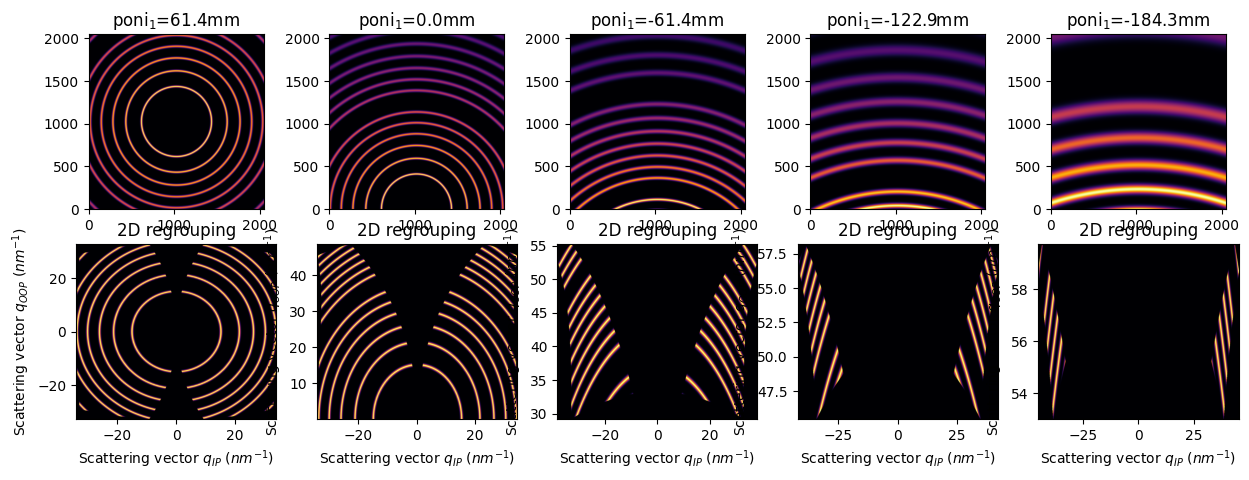

In [9]:
fis = []
imgs = []
fig, ax = subplots(2,5, figsize=(15,5))
for i in range(5):
    my_fi = copy.deepcopy(fi)
    my_fi.poni1 -= i*poni1
    my_img = LaB6.fake_calibration_image(my_fi)
    jupyter.display(my_img, label="poni$_1$=%3.1fmm"%(1e3*my_fi.poni1), ax=ax[0,i])
    res2d = my_fi.integrate2d_grazing_incidence(data=my_img)
    jupyter.plot2d(res2d, ax=ax[1,i])
    fis.append(my_fi)
    imgs.append(my_img)
    print(my_fi)

## MultiGeometryFiber integrator ##

The *MultiGeometryFiber* instance can be created from any list of *FiberIntegrator* instances or list of *poni-files*. Here we will use the former method.

The main difference of a *MultiIntegrator* with a "normal" *AzimuthalIntegrator* comes from the definition of the output space in the constructor of the object. One needs to specify the unit and the integration range.
For *MultiGeometryFiber*:
- the parameters `incident_angle`, `tilt_angle` and `sample_orientation` can be passed in the constructor of the instance
- the units (`unit_ip`, `unit_oop`) and their ranges `ip_range` and `oop_range` can also be passes in the constructor
- number of bins `npt_ip` and `npt_oop` are passed at the time of integrations

In [10]:
from pyFAI.multi_geometry import MultiGeometryFiber

In [11]:
mg = MultiGeometryFiber(fis, unit=("qip_nm^-1", "qoop_nm^-1"))
print(mg)

MultiGeometry integrator with 5 geometries on None radial range ((
qip_nm^-1
Incident_angle=0.0°
Tilt_angle=0.0°
Sample orientation=1
, 
qoop_nm^-1
Incident_angle=0.0°
Tilt_angle=0.0°
Sample orientation=1
)) and None azimuthal range (deg)


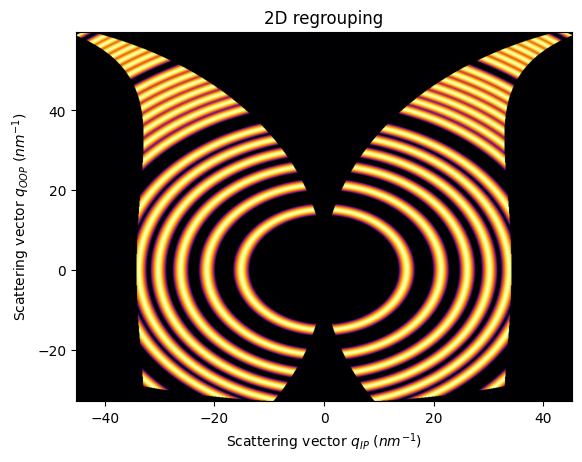

In [12]:
ax = jupyter.plot2d(mg.integrate2d(imgs))
pass

## Rotation of the detector 

The strength of translating the detector is that it simulates a larger detector, but this approach reaches its limit quikly as the higher the detector gets, the smallest the solid angle gets and induces artificial noise. One solution is to keep the detector at the same distance and rotate the detector.

This setup is common when mounting a detector on a goniometer.

### Creation of diffraction images

In this example we will use a Pilatus 200k with 2 modules. It has a gap in the middle of the two detectors and we will see how the *MultiGeometry* can help.

As previously, we will use LaB6 but instead of translating the images, we will rotate them along the second axis:

In [13]:
det = pyFAI.detectors.detector_factory("pilatus200k")
p1, p2, p3 = det.calc_cartesian_positions()
print(p3)
poni1 = p1.mean()
poni2 = p2.mean()
print(poni1)
print(poni2)

None
0.035002
0.04188201


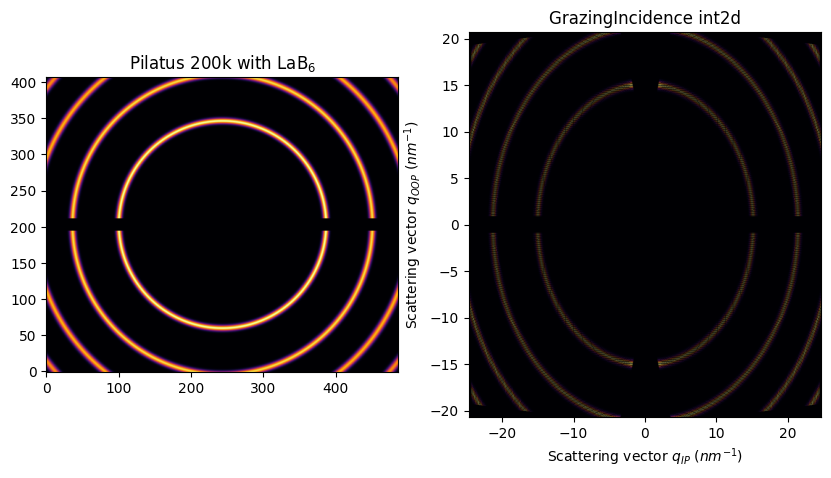

In [14]:
fi = FiberIntegrator(dist=0.1, poni1=poni1, poni2=poni2, detector=det, wavelength=wavelength)
img = LaB6.fake_calibration_image(fi)
fig, axes = jupyter.subplots(ncols=2, figsize=(10,5))
res2d_gi = fi.integrate2d_grazing_incidence(data=img)
jupyter.display(img, label="Pilatus 200k with LaB$_6$", ax=axes[0])
jupyter.plot2d(res2d_gi, label="GrazingIncidence int2d", ax=axes[1])
pass

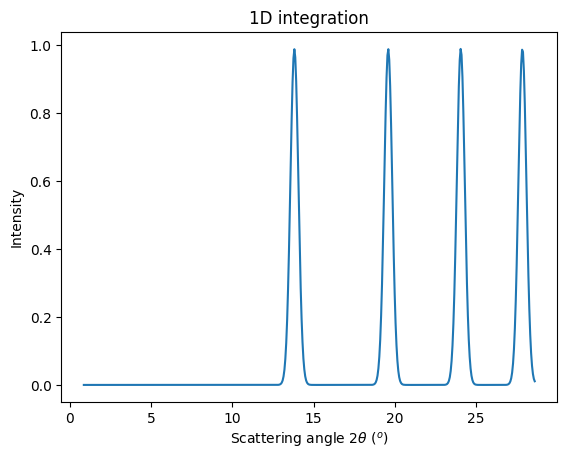

In [15]:
jupyter.plot1d(fi.integrate1d(img, 500, unit="2th_deg", method=method))
pass

We will rotate the detector with a step size of 15 degrees

Detector Pilatus 200k	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 3.500200e-02, 4.188201e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=243.500, y=203.500 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å
Incident angle: 0.00° Tilt angle 0.00° Sample orientation 1
Detector Pilatus 200k	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 3.500200e-02, 4.188201e-02 m	rot1=0.000000  rot2=-0.261799  rot3=0.000000 rad
DirectBeamDist= 103.528 mm	Center: x=243.500, y=47.716 pix	Tilt= 15.000° tiltPlanRotation= -90.000° 𝛌= 1.000Å
Incident angle: 0.00° Tilt angle 0.00° Sample orientation 1
Detector Pilatus 200k	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 3.500200e-02, 4.188201e-02 m	rot1=0.000000  rot2=-0.523599  rot3=0.000000 rad
DirectBeamDist= 115.470 mm	Center: x=243.500, y=

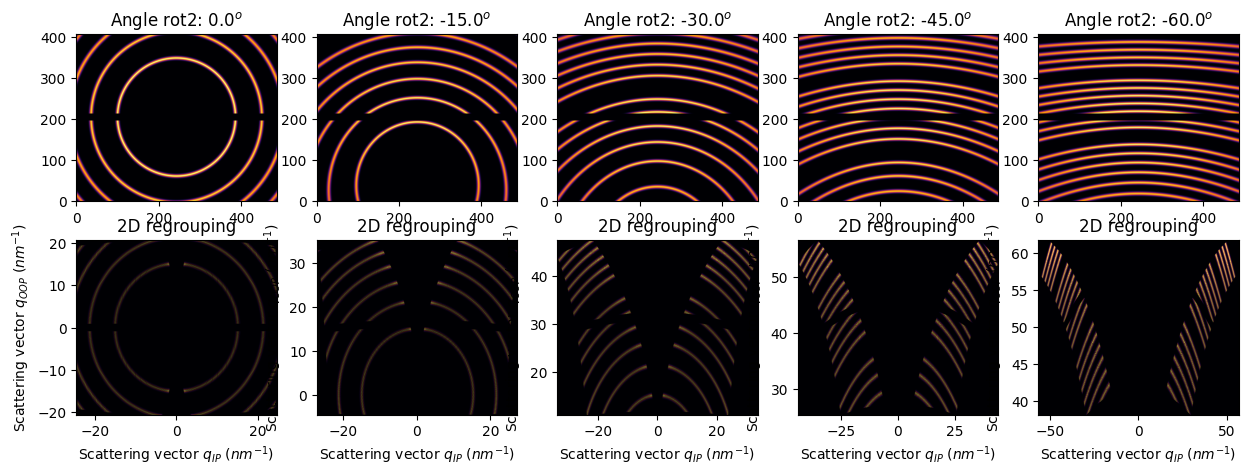

In [16]:
step = 15*numpy.pi/180
imgs = []
fis = []
fig, ax = subplots(2,5, figsize=(15,5))
for i in range(5):
    my_fi = copy.deepcopy(fi)
    my_fi.rot2 -= i*step
    my_img = LaB6.fake_calibration_image(my_fi)
    jupyter.display(my_img, label="Angle rot2: %.1f$^o$"%numpy.degrees(my_fi.rot2), ax=ax[0,i])
    res2d = my_fi.integrate2d_grazing_incidence(data=my_img)
    jupyter.plot2d(res2d, ax=ax[1,i])
    fis.append(my_fi)
    imgs.append(my_img)
    print(my_fi)

#### If we choose polar units, we can cake (remap) the image in the classic but taking into account the missing wedge

In [17]:
mg_fiber = MultiGeometryFiber(fis=fis, unit=("qtot_nm^-1", "chigi_deg"))

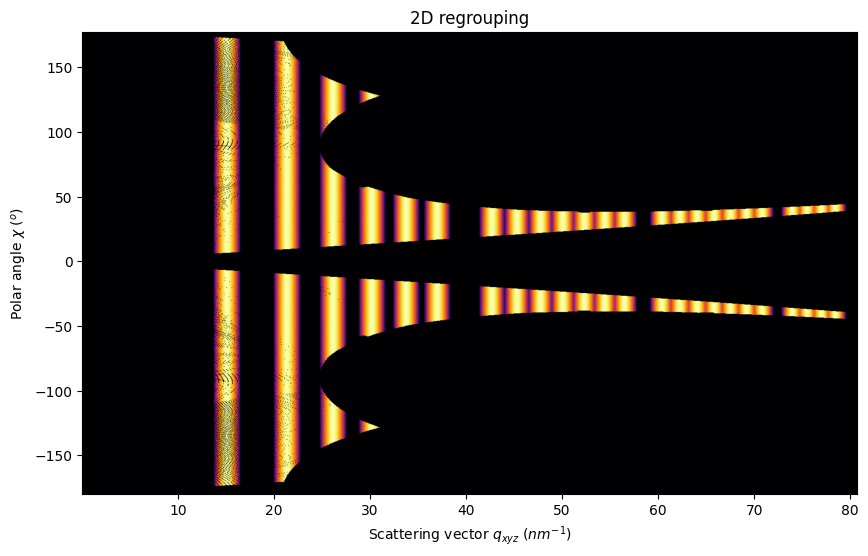

In [18]:
fig, ax = subplots(figsize=(10,6))
res2d = mg_fiber.integrate2d_grazing_incidence(lst_data=imgs)
jupyter.plot2d(result=res2d, ax=ax)
pass

#### And also getting the intensity profile integrated across the polar angle (**be careful, by default the fiber integration is vertical**)

/home/jerome/.venv/py311/lib/python3.11/site-packages/pyFAI/integrator/fiber.py:274: RuntimeWarning: invalid value encountered in divide
  intensity = sum_signal / sum_normalization


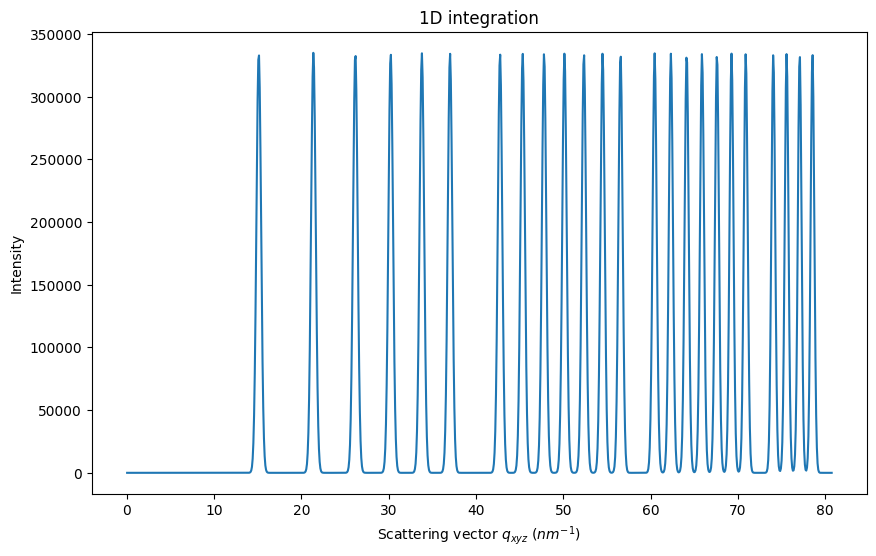

In [19]:
fig, ax = subplots(figsize=(10,6))
res1d = mg_fiber.integrate1d_grazing_incidence(lst_data=imgs, vertical_integration=False)
jupyter.plot1d(result=res1d, ax=ax)
pass

## Conclusion

The MultiGeometryFiber class of multi_geometry allows to stitch images for a grazing-incidence diffraction experiments

In [20]:
print(f"Excution time: %.3f"%(time.perf_counter()-start_time))

Excution time: 29.329
